## Machine Learning Algorithms for Time Series Analysis: Demand Forecasting

📌 In this section, we will use machine learning algorithms to perform time series analysis.

# Business Problem

📌 The objective of this competition is to predict 3 months of item-level sales data at different store locations.

# Dataset Story

**File descriptions**

* train.csv - Training data
* test.csv - Test data (Note: the Public/Private split is time based)
* sample_submission.csv - a sample submission file in the correct format

**Data fields**

* date - Date of the sale data. There are no holiday effects or store closures.
* store - Store ID
* item - Item ID
* sales - Number of items sold at a particular store on a particular date.

# Import Necessary Libraries

In [ ]:
import time
import warnings
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

warnings.filterwarnings("ignore")

# Import Dataset

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/demand_forecasting/train.csv", parse_dates=['date'])
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/demand_forecasting/test.csv", parse_dates=['date'])
sample_sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/demand_forecasting/sample_submission.csv")
df = pd.concat([train, test], sort=False)
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0000,NaN
1,2013-01-02,1,1,11.0000,NaN
2,2013-01-03,1,1,14.0000,NaN
3,2013-01-04,1,1,13.0000,NaN
4,2013-01-05,1,1,10.0000,NaN


# General Information About to the Dataset

In [ ]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

######################### Head #########################
        date  store  item   sales  id
0 2013-01-01      1     1 13.0000 NaN
1 2013-01-02      1     1 11.0000 NaN
2 2013-01-03      1     1 14.0000 NaN
3 2013-01-04      1     1 13.0000 NaN
4 2013-01-05      1     1 10.0000 NaN
######################### Tail #########################
            date  store  item  sales         id
44995 2018-03-27     10    50    NaN 44995.0000
44996 2018-03-28     10    50    NaN 44996.0000
44997 2018-03-29     10    50    NaN 44997.0000
44998 2018-03-30     10    50    NaN 44998.0000
44999 2018-03-31     10    50    NaN 44999.0000
######################### Shape #########################
(958000, 5)
######################### Types #########################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
######################### NA #########################
date          0
store         0
item          0
sales

In [ ]:
print("Min Date: " , df["date"].min(), " ,Max Date: ", df["date"].max())

Min Date:  2013-01-01 00:00:00  ,Max Date:  2018-03-31 00:00:00


In [ ]:
print("Number of Unique Store:", df["store"].nunique(), " ,Number of Unique Item:", df["item"].nunique())

Number of Unique Store: 10  ,Number of Unique Item: 50


In [ ]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [ ]:
df.groupby(["store", "item"]).agg({"sales": ["sum","mean","median","std"]})

sales                        
                   sum    mean  median     std
store item                                    
1     1     36468.0000 19.9715 19.0000  6.7410
      2     97050.0000 53.1490 52.0000 15.0058
      3     60638.0000 33.2081 33.0000 10.0725
      4     36440.0000 19.9562 20.0000  6.6406
      5     30335.0000 16.6128 16.0000  5.6721
...                ...     ...     ...     ...
10    46   120601.0000 66.0465 65.0000 18.1150
      47    45204.0000 24.7558 24.0000  7.9248
      48   105570.0000 57.8149 57.0000 15.8985
      49    60317.0000 33.0323 32.0000 10.0916
      50   135192.0000 74.0372 73.0000 19.9376

[500 rows x 4 columns]

# Feature Engineering

In [ ]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [ ]:
df = create_date_features(df)

In [ ]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0000,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0000,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0000,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0000,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0000,NaN,1,5,5,1,5,2013,1,0,0


# Create Lag/Shifted Features

In [ ]:
def random_noise(dataframe, scale=1.6):
  return np.random.normal(scale=scale, size=(len(dataframe), ))

In [ ]:
def lag_features(dataframe, lags):
  dataframe.sort_values(by=['store', 'item','date'], axis=0, inplace=True)
  for lag in lags:
    dataframe['sales_lag_' + str(lag)] = dataframe.groupby(['store','item'])['sales'].transform(
        lambda x: x.shift(lag)) + random_noise(dataframe)
  return dataframe

In [ ]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0000,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0000,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0000,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0000,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0000,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Rolling Mean Features

In [ ]:
def roll_mean_features(dataframe, windows):
  for window in windows:
    dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(['store', 'item'])['sales'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type='triang').mean()) + random_noise(dataframe)
  return dataframe

In [ ]:
df = roll_mean_features(df, [365, 546])
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0000,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0000,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0000,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0000,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0000,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exponentially Weighted Mean Features

In [ ]:
def ewm_features(dataframe, alphas, lags):
  for alpha in alphas:
    for lag in lags:
      dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = dataframe.groupby(['store', 'item'])['sales'].transform(
          lambda x: x.shift(lag).ewm(alpha=alpha).mean())
  return dataframe

In [ ]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0000,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0000,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0000,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0000,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0000,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# One-Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])
df.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0000,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0000,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0000,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0000,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10.0000,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
df.shape

(958000, 146)

# Converting sales to log(1+sales)

In [ ]:
df['sales'] = np.log1p(df['sales'].values)

In [ ]:
check_df(df)

######################### Head #########################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_270  \
0 2013-01-01 2.6391 NaN             1            1             1  2013        0               1             0           NaN           NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN                  NaN                  NaN                         NaN                         NaN                          NaN                          NaN                          NaN                          

# Cost Function

In [ ]:
# MAPE: mean absolute percentage error
def mape(preds, target):
  mape = np.mean(np.abs((target - preds) / target))*100
  return mape

def lgbm_mape(preds, train_data):
    labels = train_data.get_label()
    mape_val = mape(np.expm1(preds), np.expm1(labels))
    return 'MAPE', mape_val, False

In [ ]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# Time-Based Validation Sets: Splitting Dataset

In [ ]:
train = df.loc[(df["date"] < "2017-01-01"), :]
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ["date", "id", "sales", "year"]]

Y_train = train["sales"]
X_train = train[cols]

Y_val = val["sales"]
X_val = val[cols]

print(Y_train.shape, X_train.shape, Y_val.shape, X_val.shape)

(730500,) (730500, 142) (45000,) (45000, 142)


# Create a Base Model: Lightgbm

In [ ]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain, 
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'], 
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, verbose_eval=100)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.585850 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513047	training's SMAPE: 17.5902	valid_1's l2: 0.0530908	valid_1's SMAPE: 17.4605
[200]	training's l2: 0.0352027	training's SMAPE: 14.5669	valid_1's l2: 0.0369695	valid_1's SMAPE: 14.8761
[300]	training's l2: 0.0324278	training's SMAPE: 14.0127	valid_1's l2: 0.0340832	valid_1's SMAPE: 14.4159
[400]	training's l2: 0.0313598	training's SMAPE: 13.799	valid_1's l2: 0.0332267	valid_1's SMAPE: 14.2654
[500]	training's l2: 0.0306906	training's SMAPE: 13.6665	valid_1's l2: 0.0326824	valid_1's SMAPE: 14.1491
[600]	training's l2: 0.0302345	training's SMAPE: 13.5718	valid_1's l2: 0.0322324	valid_1's SMAPE: 14.0478
[700]	training's l2: 0.0299063	training's SMAPE: 13.5015	valid_1's l2: 0.0318668	valid_1's SMAPE: 13.9629
[800]	training's l2: 0.0296252	t

13.830001110124451

In [ ]:
model = lgb.train(lgb_params, lgbtrain, 
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'], 
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_mape, verbose_eval=100)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
mape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.133710 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513047	training's MAPE: inf	valid_1's l2: 0.0530908	valid_1's MAPE: 20.4076
[200]	training's l2: 0.0352027	training's MAPE: inf	valid_1's l2: 0.0369695	valid_1's MAPE: 16.4715
[300]	training's l2: 0.0324278	training's MAPE: inf	valid_1's l2: 0.0340832	valid_1's MAPE: 15.5859
[400]	training's l2: 0.0313598	training's MAPE: inf	valid_1's l2: 0.0332267	valid_1's MAPE: 15.3115
[500]	training's l2: 0.0306906	training's MAPE: inf	valid_1's l2: 0.0326824	valid_1's MAPE: 15.1522
[600]	training's l2: 0.0302345	training's MAPE: inf	valid_1's l2: 0.0322324	valid_1's MAPE: 15.0193
[700]	training's l2: 0.0299063	training's MAPE: inf	valid_1's l2: 0.0318668	valid_1's MAPE: 14.902
[800]	training's l2: 0.0296252	training's MAPE: inf	valid_1's l2: 0.031647

14.732483696417104

# Feature Importance

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

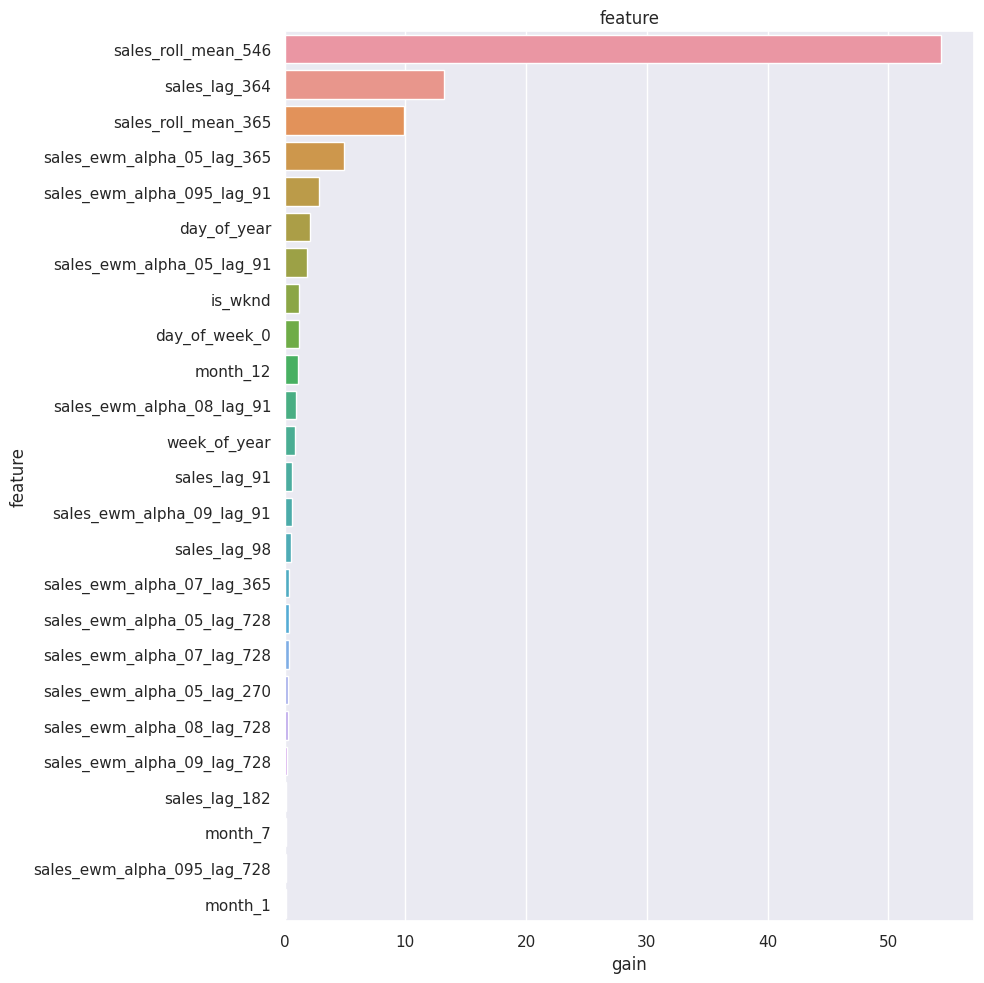

In [ ]:
feat_imp = plot_lgb_importances(model, plot=True, num=30)

In [ ]:
# Remove zero importance features
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

110

# Final Model

In [ ]:
train = df.loc[~df.sales.isna()]
Y_train = train["sales"]
X_train = train[imp_feats]

test = df.loc[df.sales.isna()]
Y_test = test["sales"]
X_test = test[imp_feats]

In [ ]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=imp_feats)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.025823 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [ ]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

# Submission File: Kaggle Format

In [ ]:
submission_df = test.loc[:,["id", "sales"]]
submission_df["sales"] = np.expm1(test_preds)
submission_df["id"] = submission_df["id"].astype(int)
submission_df.to_csv("submission_demand.csv", index=False)